### Capstone Submission: Data Wrangling 
Created December 27, 2021

Intent of this notebook is to pre-process the labels to work with a supervised DL model via PyTorch

In [76]:
# from PIL import Image
import cv2
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import json 

import os

In [2]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
torch.__version__

'1.11.0.dev20211231'

In [38]:
# image & pytorch properties 
WIDTH = 512
HEIGHT = 512
category_num = 46 + 1 

In [5]:
df = pd.read_csv('/Users/narekgeghamyan/local_data/capstone_data/imaterialist-fashion-2019-FGVC6/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331213 entries, 0 to 331212
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        331213 non-null  object
 1   EncodedPixels  331213 non-null  object
 2   Height         331213 non-null  int64 
 3   Width          331213 non-null  int64 
 4   ClassId        331213 non-null  object
dtypes: int64(2), object(3)
memory usage: 12.6+ MB


In [5]:
df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [8]:
label_desc_json_file = '/Users/narekgeghamyan/local_data/capstone_data/imaterialist-fashion-2019-FGVC6/label_descriptions.json'
json_file = open(label_desc_json_file)
label_description = json.load(json_file)

In [42]:
# train image directory
# sys.path.insert(0, '/Users/narekgeghamyan/local_data/capstone_data/')
data_dir = '/Users/narekgeghamyan/local_data/capstone_data/imaterialist-fashion-2019-FGVC6/train/'
data_list = os.listdir('/Users/narekgeghamyan/local_data/capstone_data/imaterialist-fashion-2019-FGVC6/train/')
print('Number of training images: ' + str(len(data_list)))

Number of training images: 45195


In [18]:
label_description.keys()

dict_keys(['info', 'categories', 'attributes'])

In [27]:
label_description['categories']

[{'id': 0, 'name': 'shirt, blouse', 'supercategory': 'upperbody', 'level': 2},
 {'id': 1,
  'name': 'top, t-shirt, sweatshirt',
  'supercategory': 'upperbody',
  'level': 2},
 {'id': 2, 'name': 'sweater', 'supercategory': 'upperbody', 'level': 2},
 {'id': 3, 'name': 'cardigan', 'supercategory': 'upperbody', 'level': 2},
 {'id': 4, 'name': 'jacket', 'supercategory': 'upperbody', 'level': 2},
 {'id': 5, 'name': 'vest', 'supercategory': 'upperbody', 'level': 2},
 {'id': 6, 'name': 'pants', 'supercategory': 'lowerbody', 'level': 2},
 {'id': 7, 'name': 'shorts', 'supercategory': 'lowerbody', 'level': 2},
 {'id': 8, 'name': 'skirt', 'supercategory': 'lowerbody', 'level': 2},
 {'id': 9, 'name': 'coat', 'supercategory': 'wholebody', 'level': 2},
 {'id': 10, 'name': 'dress', 'supercategory': 'wholebody', 'level': 2},
 {'id': 11, 'name': 'jumpsuit', 'supercategory': 'wholebody', 'level': 2},
 {'id': 12, 'name': 'cape', 'supercategory': 'wholebody', 'level': 2},
 {'id': 13, 'name': 'glasses', 'su

In [120]:
# filename = data_dir + data[123]
filename = data_dir + data_list[data_list.index(df.iloc[1].ImageId)]

In [121]:
# using Pillow
# img = Image.open(filename)
# img.size

# using OpenCV
img = cv2.imread(filename)
img.shape

(5214, 3676, 3)

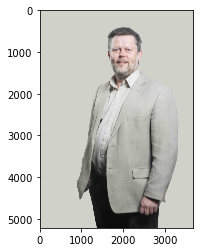

In [122]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [36]:
def make_mask_img(segment_df):
    seg_width = segment_df.at[0, "Width"]
    seg_height = segment_df.at[0, "Height"]
    seg_img = np.full(seg_width*seg_height, category_num-1, dtype=np.int32)
    for encoded_pixels, class_id in zip(segment_df["EncodedPixels"].values, segment_df["ClassId"].values):
        pixel_list = list(map(int, encoded_pixels.split(" ")))
        for i in range(0, len(pixel_list), 2):
            start_index = pixel_list[i] - 1
            index_len = pixel_list[i+1] - 1
            seg_img[start_index:start_index+index_len] = int(class_id.split("_")[0])
    seg_img = seg_img.reshape((seg_height, seg_width), order='F')
    seg_img = cv2.resize(seg_img, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
    return seg_img

In [92]:
def create_image_batch(df):
    img_ind_num = df.groupby("ImageId")["ClassId"].count()
    index = df.index.values[0]
    trn_images = []
    seg_images = []
    for i, (img_name, ind_num) in enumerate(img_ind_num.items()):
        img = cv2.imread(data_dir + img_name)
        img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
        segment_df = (df.loc[index:index+ind_num-1, :]).reset_index(drop=True)
        index += ind_num
        if segment_df["ImageId"].nunique() != 1:
            raise Exception("Index Range Error")
        seg_img = make_mask_img(segment_df)
        
        # HWC -> CHW
        # img = img.transpose((2, 0, 1))
        #seg_img = seg_img.transpose((2, 0, 1))
        
        trn_images.append(np.array(img, dtype=np.float32)/255 )
        seg_images.append(np.array(seg_img, dtype=np.int32))
    return(trn_images, seg_images)

In [93]:
df_temp = df.iloc[:50]
trained, segmented = create_image_batch(df_temp)

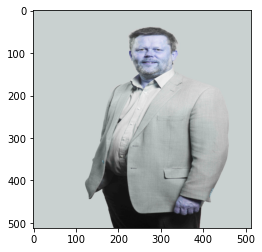

In [115]:
# plt.imshow(trained[0].transpose(1,2,0))
plt.imshow(trained[0])

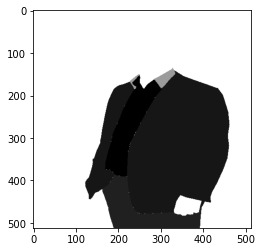

In [133]:
plt.imshow(segmented[0], cmap='gray')

### Summary
#### The above image demonstrate pre-processing by: 
<P> 1. Resizing image, <P> 2. Normalizing image, <P> 3. Creating a mask for each image, <P> and 4. Turnign the images into arrays so they may be used for training